<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/single_subject/DataExplorationofSingleSubject_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration of Single Subject SVM
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook runs exploration of different normalization strategies for brain data and performs cross-validation. You can visualize and analyze data in place or you can save the data and do it in a separate notebook. This will demonstrate how to do it in place. 
> Normalization Strategies
  1. Choose run(s) to train on
  2. Choose run(s) to test on
  3. Choose from the following for normalization ['psc','zscore','nonorm'].
    * This is a list of of normalizations to apply to the data. It will iterate through the list.
  4. Choose params for C, kernel, gamma. If not specified, default will be used.
  5. Choose list of subjects to save. I saved one adult and one child for visualizations
  6. Choose output file name.
  7. The cell for normalization will iterate over all subjects unless, you choose a subset.
  8. Output will be a pandas dataframe with accuracy and F1 scores of the subjects.
  9. The subject models variables are stored in a dictionary for further analysis and visualiztions.
    * Variables Stored 
      1. clf
      2. X-train
      3. y-train (even though all runs have same labels, we want to store this separately in case we train on two runs where labels will be concatenated).
      4. y_labels (since we test on single runs and all runs have the same data, we just need on set of labels)
      5. scaled data of each run so we can look at decision function boundaries
      6. Since the data has been transformed and stripped, we can save this locally. You can either choose to analyze immediatly or save data for analysis later.
  10. Create summary statistics for all subjects. I also chose to look at differences between adolescents and young adults.
  11. Create boxplots.
  12. Create heatmaps of brains based on normalization.
  13. Look at results of decision function scores overlaying on increase/decrease trials within a run.

> Cross-validation
  * Once we have the best normalization for our data, run the cross validation
    1. Choose the run(s) to perform cross validation on.
    2. Choose runs to get accuracy measures on from the cv on the subjects(?)
    3. Choose params you want to do cross-validation on.
    4. Choose output destination. If further analysis is needed.
      * Output is a dictionary containing the model for each subject.
    5. Loop through subjects to get results of cross validation.
      * Data is stored in a data frame.
    6. Create boxplot of results.






### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/single_subject
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 2472, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 2472 (delta 203), reused 266 (delta 153), pack-reused 2125
Receiving objects: 100% (2472/2472), 164.32 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (1594/1594), done.
/content/teambrainiac/source/single_subject
access_data.py					single_subject.py
brain_viz_single_subj.py			SingleSubjectSVM.ipynb
BuildSingleSubjectSVM_Models.ipynb		SingleSubjectSVM_Norm_CV.ipynb
data						SingleSubjSVM_Analysis.ipynb
DataExplorationNotebook_SingleSubjectSVM.ipynb	VisualizationPlayground.ipynb
__init__.py					VisualizationsNotebook.ipynb
process.py


### Load path_config.py 
- we are already in source so we can just load this file without changing directory

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [ ]:


# Import libraries
!pip install boto3 nilearn nibabel #for saving data and image visualizations
import pickle
#sklearn packages needed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score,roc_curve,f1_score
#important utility functions for loading,masking,saving data
from access_data import *
#single subject model building functions
from single_subject import *
#for visualization(s)
from brain_viz_single_subj import *
#import visualizations packages
import nibabel as nib
from nilearn import plotting, image
#for making graphs
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns
from nilearn.image import threshold_img
#normal python packages we use
import numpy as np
import pandas as pd
#for normalizatoin
from nilearn.signal import clean

### Get paths to subject data

#####Get Common Variables we need for Notebook

In [ ]:
#get common variables we need across multiple cells
data_path_dict = get_data_dict()

##get brain images
affine_image,t1_image,mni_image = get_brain_templates()

Run Normalization

In [ ]:

###data exploration for different normalization strategies
##what runs do you want to normalize on
runs_train=['run_02'] #runs we want to train on
runs_test=['run_03','run_04'] #runs we want to test on
runs_list=[1,2,3,4]
##for fMRI, we always want to detrend the data
norm_list = ['psc','zscore','none'] #list of normalization strategies you want to test
save_subject_data =  ['10047_09030','30017_09567'] #specify subjects you want to save for normalization visualizations
svc_kernel='rbf' #specify kernel 
svc_c = 1 #specify c parameter
svc_gamma='scale' #specify gamma parameter
mask_dict = get_mask_data(data_path_dict,0) #get mask_dict
mask,_ = make_mask(mask_dict['mask']) #create mask
#get subject information
subjs_id, subjs_paths = get_subj_information(data_path_dict)
#get mask labels to only retrieve time series we care about
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
###initialize variables to hold results
model_dict = {}
results = []
df_columns = ['subject_id','norm_type']
##for demonstration purposes only uncomment for demonstration
subjs_id = subjs_id[0:5]
save_subject_data = subjs_id
print(subjs_id)
#iterate over norm_type to get initialize model_dict norm_type dictionary
for norm_type in norm_list:
  model_dict[norm_type] = {}
#iterate over subjects
for idx in range(len(subjs_id)):
  subj_id = subjs_id[idx] #get subj_id
  subj_path = subjs_paths[idx] #get subj_path
  subj_data = access_load_data(subj_path,True) #get subj_data
  masked_data = mask_subject_data(subj_data,mask,mask_labels_indices) #mask subject data
  #loop over normalizations to do
  for norm_type in norm_list:
    norm_results = [subj_id,norm_type] #store subject id and normalization strategy in results list
    scaled_data = scale_data_single_subj(masked_data,runs_list,norm=norm_type) #scale the data for runs listed in runs_lit
    clf,X_train,y_train = run_single_subject_svm(scaled_data,runs_train,binary_labels,svc_kernel,svc_gamma,svc_c) #run the model
    if subj_id in save_subject_data:    #if subject in list of subjects to save
      model_dict[norm_type][subj_id] = {} #initialize empty dictionary for the subject data
      #store subject variables
      model_dict[norm_type][subj_id]['model'] = clf
      model_dict[norm_type][subj_id]['X_train'] = X_train
      model_dict[norm_type][subj_id]['y_train'] = y_train
      model_dict[norm_type][subj_id]['y_test'] = binary_labels
      model_dict[norm_type][subj_id]['data'] = scaled_data
    sub_scores,cols = get_accuracy_scores(clf,scaled_data,X_train,y_train,runs_test,binary_labels) #get accuracy scores for analysis
    norm_results.extend(sub_scores) #append to list
    results.append(norm_results) #append to results
df_columns.extend(cols) #extend data frame columns
norm_results_df = pd.DataFrame(results,columns=df_columns) #create df
#save results for analysis
save_data_path = f'/content/drive/My Drive/data/dataexploration/{svc_kernel}_exploration/accuracy_results.csv'
norm_results_df.to_csv(save_data_path)
#save models for visualization
save_models_path = f'/content/drive/My Drive/data/dataexploration/{svc_kernel}_exploration/norm_models.pkl'
filehandler = open(save_models_path,"wb")
pickle.dump(model_dict,filehandler)
filehandler.close()

['10004_08693', '10008_09924', '10009_08848', '10016_09694', '10017_08894']


/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals -

###Explore Normalization Approaches

In [ ]:
##create summary statistics for the three df (all,adolescent,young adult)

stats_norm_all = norm_results_df.groupby(['norm_type']).mean()
stats_norm_all.reset_index(inplace=True) #reset index
print(stats_norm_all)


  norm_type  train_acc  run_03_acc  run_03_f1_score  run_04_acc  \
0      none   0.985714    0.688095         0.702390    0.723810   
1       psc   0.847619    0.604762         0.432911    0.609524   
2    zscore   0.988095    0.738095         0.732595    0.714286   

   run_04_f1_score  
0         0.693716  
1         0.432480  
2         0.695365  


####Get Boxplots


---


We do this to show the spread across the subjects.
As the visualization shows there is quite a difference between subjects. This 
is to be expected as individuals differ in how well they may regulate. You can also see from the charts and above statistics that normalizing the data by z normalization gives us the best accuracy results.

Run 03 gives better results and this makes sense because run 03 is a feedback run where the participants are being told how well the are regulating the NAcc. In run_04, they are not given any feedback.


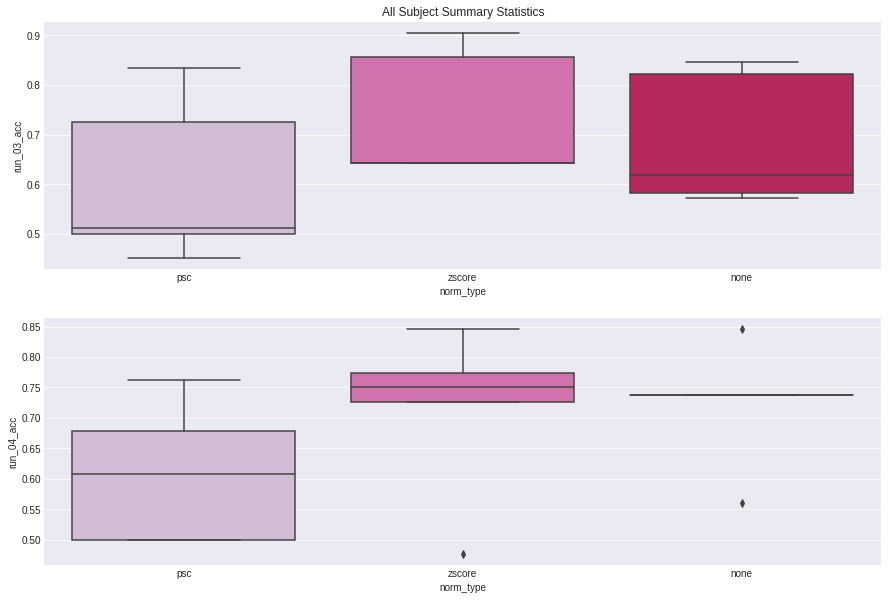

In [ ]:
##create box plots accross all subjects
fig,axes=plt.subplots(2,1,figsize=(15,10)) #get figure size
plt.style.use('seaborn-darkgrid')
sns.boxplot(x='norm_type',y='run_03_acc',data=norm_results_df, ax=axes[0],palette='PuRd')
sns.boxplot(x='norm_type',y='run_04_acc',data=norm_results_df, ax=axes[1],palette='PuRd')  
axes[0].set_title('All Subject Summary Statistics')


##uncomment to save results
# fig.savefig('/content/drive/My Drive/data/dataexploration/rbf_exploration/normalization_boxplot.png',dpi=200)
plt.show()


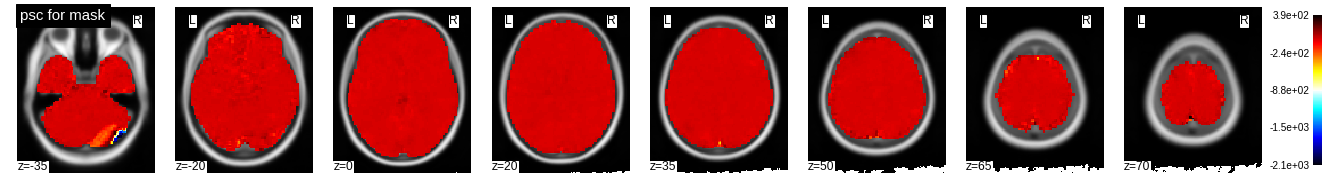

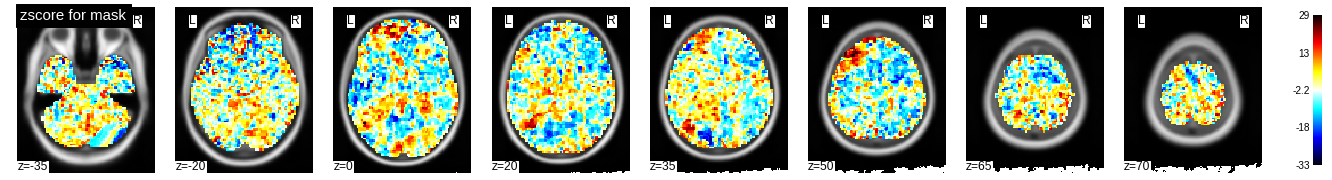

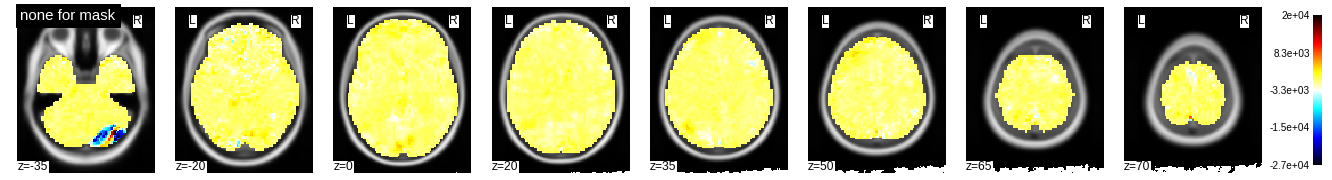

In [ ]:
#cell for displaying data
outf_path = None #change to path name if want to say images. Just need path (filename appended in function call)
mask_data = get_mask_data(data_path_dict,0) #grab indices of mask to use
_,ind = make_mask(mask_data['mask']) #make mask (flatten to 1-d array of boolean values FALSE=NOT PART OF BRAIN, TRUE=BRAIN)
#iterate over norm types
for norm_type in list(model_dict.keys()):
  norm_models = model_dict[norm_type]
  subj_list = list(norm_models.keys())
  #to only display one uncomment
  subj_list = [subj_list[0]]
  for idx in range(len(subj_list)):
    subj_id = subj_list[idx]
    subj_data = norm_models[subj_id]
    bmap3=None #set bmap3 to none (nilearn is fickle)
    disp_image=None #set disp image to none (nilearn is fickle)
    #get subject model dictionary
    _,bmap3_nii = create_bmaps(subj_data,ind,affine_image) #grab bmap3 (nifti)
    plot_map(bmap3_nii,norm_type,'mask',out_fname=outf_path,threshold=.0001,t_image=mni_image) #get image

#####Decision Function Plots
* These plots show the score of the timepoints and how the svm will predict. Above 0  = increase brain state, below zero = decrease brain state. We can see through this how well the model is predicting at each time point.

/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_psc.png
/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_psc.png
/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_zscore.png
/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_zscore.png
/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_none.png
/content/drive/My Drive/data/dataexploration/rbf_exploration/Whole Brain Mask_descf_none.png


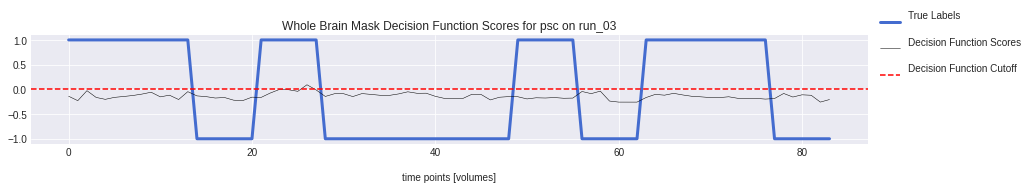

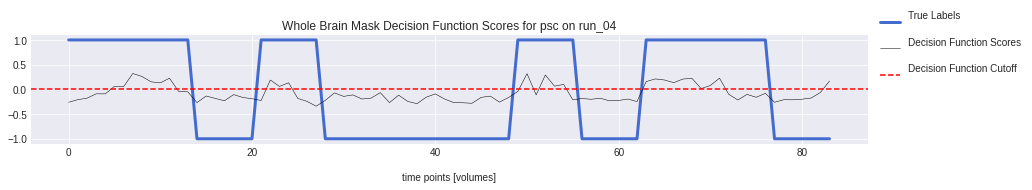

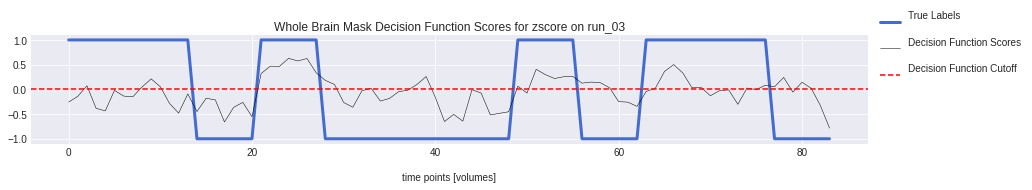

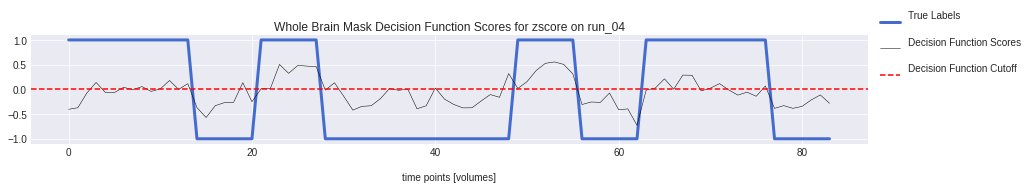

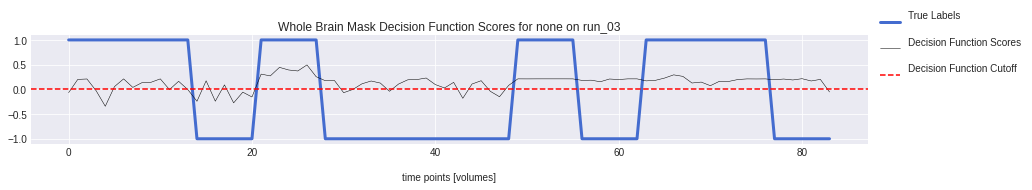

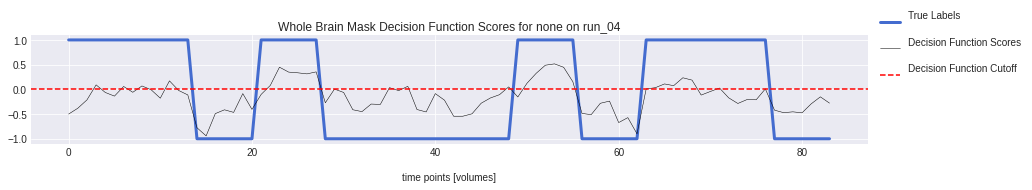

In [ ]:
runs_test = ['run_03','run_04'] ##which runs do we want to test on
outf_path = '/content/drive/My Drive/data/dataexploration/rbf_exploration/'
for norm_type in list(model_dict.keys()): #iterate over norm types
  norm_models = model_dict[norm_type] #get normtype subject models
  subj_list = list(norm_models.keys()) 
  #to only display one uncomment
  subj_list = [subj_list[0]]
  #iterate over subjects
  for idx in range(len(subj_list)):
    subj_id = subj_list[idx] #subjectid
    subj_data = norm_models[subj_id] #get subject data
    #get predictions returns subject predictions from clf
    subj_predicts = get_predicts(subj_data['model'],subj_data['data'],runs_test)
    #iterate over runs to display
    for run in runs_test:
      decf_scores = subj_predicts[run]['decision_function'] #get decision score
      decision_function_labels = np.where(subj_data['y_test']==0,-1,1) #put scores in range of -1, 1 to match svm outputs
      plot_decision_scores(decf_scores,decision_function_labels,norm_type,'Whole Brain Mask',run,outf_path)


###Cross-Validation

####Create Summary Statistics DataFrame and Boxplot Visualization

In [ ]:
cv_dict = {} #initialize the results dictionary
destination_path = '/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_short.pkl' #where to save data
runs_train=['run_01','run_02'] #runs we want to train on
runs_list=[1,2,3,4] #runs we want to do cv on
runs_test=['run_03','run_04']
cv_params = {'C':[1, 5, 10,1000],'gamma': ['auto','scale']} #params we want to test
subjs_id,subjs_paths = get_subj_information(data_path_dict) #get subject information
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict) #get labels
mask_dict = get_mask_data(data_path_dict,0) #get mask dictionary containing mask data
mask,_ = make_mask(mask_dict['mask']) #mask we want to use in cv
norm_type = 'zscore' #which normalization we want
#uncomment to run on 5 subjects for demonstration purposes
subjs_id = subjs_id[0:5]
#iterate over subjects and perform cv single subject svm
for idx in range(len(subjs_id)):
  subj_id = subjs_id[idx] #get subject id
  subj_path = subjs_paths[idx] #get path to subject data
  subj_data = access_load_data(subj_path,True)  #load subject data
  masked_data = mask_subject_data(subj_data,mask,mask_labels_indices) #mask the data
  scaled_data = scale_data_single_subj(masked_data,runs_list,norm=norm_type) #normalize the data
  clf = run_single_subject_svm(scaled_data,runs_train,binary_labels,do_cv=True,params=cv_params) #run cross validation
  cv_dict[subj_id] = {} #initialize subject dictionary
  cv_dict[subj_id]['model'] = clf #save cv model for further analysis
#save data
filehandler = open(destination_path,"wb")
pickle.dump(cv_dict,filehandler)
filehandler.close() 

###Cross-Validation

####Create Summary Statistics DataFrame and Boxplot Visualization

                 Cross Validation Parameters     
mean_test_score  Kernel: RBF C: 1 Gamma: auto        0.772335
                 Kernel: RBF C: 1 Gamma: scale       0.772335
                 Kernel: RBF C: 10 Gamma: auto       0.759216
                 Kernel: RBF C: 10 Gamma: scale      0.759216
                 Kernel: RBF C: 1000 Gamma: auto     0.759216
                 Kernel: RBF C: 1000 Gamma: scale    0.759216
                 Kernel: RBF C: 5 Gamma: auto        0.759216
                 Kernel: RBF C: 5 Gamma: scale       0.759216
dtype: float64


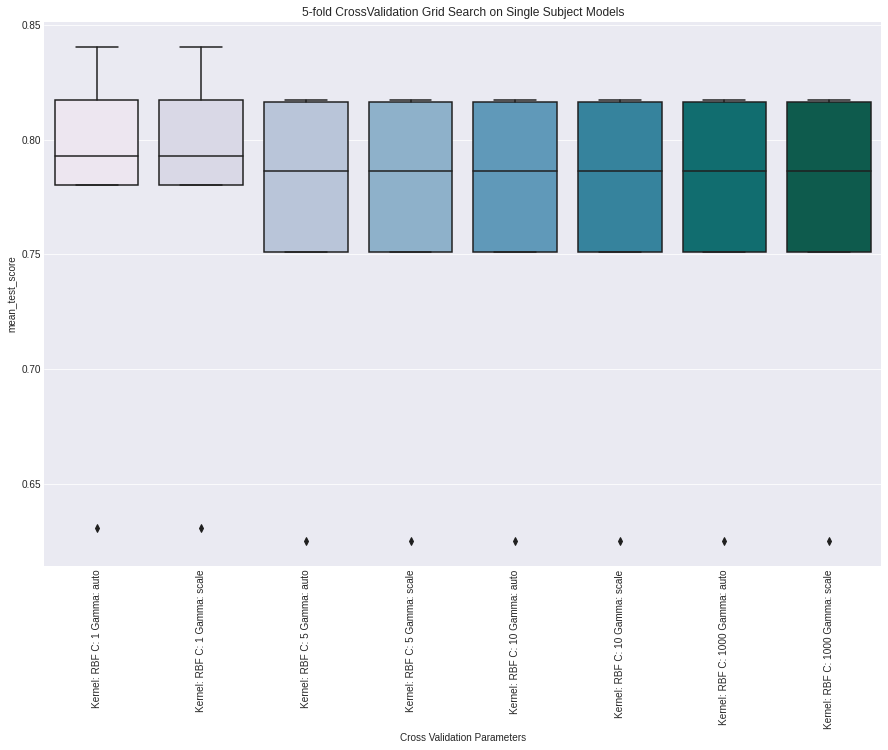

In [ ]:
###cell to look at cross validation results on run 2 over all subjects
#create for loop to create summary df of cross validation results using decision function ovr
final_df = pd.DataFrame() #initialize df
#loop over subjects
for sub_id in subjs_id:
  model = cv_dict[sub_id]['model'] #load model from dictionary
  model.cv_results_ #get cv_results
  model_df = pd.DataFrame(model.cv_results_) #convert to dataframe
  model_df['subject'] = sub_id #add subject id column
  sub_df = model_df[['subject','param_C', 'param_gamma','mean_test_score','std_test_score']] #grab columns of interest
  #create df
  if len(final_df)==0:
    final_df = sub_df
  else:
    final_df = pd.concat([final_df,sub_df])

#get summary statistics for cross validation
stats_df = final_df.groupby(['param_C','param_gamma']).agg({'mean_test_score': ['mean','std']})
##add column to condense param_c and param_kernel for plotting purposes
final_df['Cross Validation Parameters'] = "Kernel: RBF" + " C: " + final_df['param_C'].astype(str) + " Gamma: " + final_df['param_gamma'].astype(str)
#create a sub_df for graph
cv_results_graph_df = final_df[['subject','Cross Validation Parameters','mean_test_score',]]
#create a df to export for summary statistics in excel
final_df_wide = pd.pivot_table(cv_results_graph_df,index = ['subject'],columns=['Cross Validation Parameters'],values=['mean_test_score'])
final_df_summary = final_df_wide.mean() ##get mean across rows
print(final_df_summary)
##save results
final_df_wide.to_csv('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_tr_2_te_3_4.csv')

##plot cross validation results
fig,axes=plt.subplots(1,figsize=(15,10))
plt.style.use('seaborn-darkgrid')
plt.title('5-fold CrossValidation Grid Search on Single Subject Models')
sns.boxplot(x='Cross Validation Parameters',y='mean_test_score',data=cv_results_graph_df,palette="PuBuGn",ax=axes)
plt.xticks(rotation=90)
#save figure
fig.savefig('/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results_tr_2_te_3_4.png',dpi=200)
plt.show()
